CELL 1 – Install Dependencies

In [ ]:
!pip install -q tensorflow opencv-python matplotlib scikit-image tqdm

CELL 2 — Imports

In [ ]:
# Step 2: imports and helpers
import os, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as sk_psnr, structural_similarity as sk_ssim

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Display helper
def show_images(list_of_images, titles=None, figsize=(12,4)):
    n = len(list_of_images)
    plt.figure(figsize=figsize)
    for i, img in enumerate(list_of_images):
        plt.subplot(1, n, i+1)
        plt.axis('off')
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(np.clip(img, 0, 1))
        if titles:
            plt.title(titles[i])
    plt.show()


CELL 3 — Download Oxford Flowers and extract

In [ ]:
# Step 3: download Oxford Flowers dataset (auto)
import tarfile, tensorflow as tf

dataset_path = tf.keras.utils.get_file(
    "flower_photos.tgz",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
)
if not os.path.exists("flower_photos"):
    with tarfile.open(dataset_path, 'r:gz') as tar:
        tar.extractall()
DATA_DIR = "flower_photos"
print("DATA_DIR:", DATA_DIR, "exists:", os.path.exists(DATA_DIR))


CELL 4 — Load, preprocess (denoise + CLAHE), convert to Lab, normalize

Loading & preprocessing: 100%|██████████| 500/500 [00:22<00:00, 22.29it/s]


Loaded shapes: (500, 128, 128, 1) (500, 128, 128, 2)


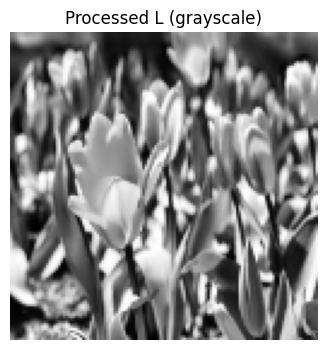

In [ ]:
# Step 4: load + image-processing enhancements (denoise + CLAHE) + convert to Lab
IMG_SIZE = (128, 128)     # CPU-friendly size (good tradeoff)
MAX_IMAGES = 500          # CPU-focused: reduced dataset to keep runtime reasonable

def preprocess_and_convert(data_dir, size=IMG_SIZE, max_images=MAX_IMAGES):
    files = []
    for root, _, fnames in os.walk(data_dir):
        for f in fnames:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                files.append(os.path.join(root, f))
    random.shuffle(files)
    files = files[:max_images]
    L_list, ab_list = [], []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    for fp in tqdm(files, desc="Loading & preprocessing"):
        img = cv2.imread(fp)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
        # Convert to Lab (uint8 expected)
        lab = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2LAB).astype(np.float32)
        L_channel = lab[...,0]      # 0..255
        a_channel = lab[...,1]      # 0..255 (128-centered)
        b_channel = lab[...,2]

        # Denoise L: operates on uint8
        L_uint8 = L_channel.astype(np.uint8)
        denoised = cv2.fastNlMeansDenoising(L_uint8, None, h=8, templateWindowSize=7, searchWindowSize=21)

        # CLAHE on denoised L
        equalized = clahe.apply(denoised)  # uint8

        # Normalize:
        L_norm = equalized.astype(np.float32) / 255.0        # 0..1
        a_norm = (a_channel - 128.0) / 128.0                 # ~ -1..1
        b_norm = (b_channel - 128.0) / 128.0

        L_list.append(L_norm[..., np.newaxis].astype(np.float32))
        ab_list.append(np.stack([a_norm, b_norm], axis=-1).astype(np.float32))

    L_arr = np.array(L_list, dtype=np.float32)
    ab_arr = np.array(ab_list, dtype=np.float32)
    return L_arr, ab_arr

L_images, ab_images = preprocess_and_convert(DATA_DIR)
print("Loaded shapes:", L_images.shape, ab_images.shape)

# Quick visual check (show the L channel and an approximate ab visualization)
idx = np.random.randint(0, len(L_images))
show_images([L_images[idx].squeeze()], titles=["Processed L (grayscale)"])


CELL 5 — Train/val split

In [ ]:
# Step 5: split into train/val and create tf.data datasets
L_train, L_val, ab_train, ab_val = train_test_split(L_images, ab_images, test_size=0.1, random_state=SEED)
print("Train:", L_train.shape, "Val:", L_val.shape)

BATCH = 8    # CPU-friendly batch
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(Ls, abs_, batch=BATCH, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((Ls, abs_))
    if shuffle:
        ds = ds.shuffle(buffer_size=1024, seed=SEED)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(L_train, ab_train, batch=BATCH, shuffle=True)
val_ds = make_dataset(L_val, ab_val, batch=BATCH, shuffle=False)


CELL 6 — Build the ConvNet base (U-Net-ish)

In [ ]:
# Step 6: build a compact U-Net-like ConvNet for base colorization (L -> ab)
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_convnet_base(input_shape=(IMG_SIZE[1], IMG_SIZE[0], 1)):
    inputs = layers.Input(shape=input_shape)
    c1 = conv_block(inputs, 48); p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 96);    p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 192);   p3 = layers.MaxPooling2D()(c3)
    b  = conv_block(p3, 384)
    u3 = layers.UpSampling2D()(b); u3 = layers.Concatenate()([u3, c3]); c4 = conv_block(u3, 192)
    u2 = layers.UpSampling2D()(c4); u2 = layers.Concatenate()([u2, c2]); c5 = conv_block(u2, 96)
    u1 = layers.UpSampling2D()(c5); u1 = layers.Concatenate()([u1, c1]); c6 = conv_block(u1, 48)
    outputs = layers.Conv2D(2, 1, activation='tanh')(c6)   # predict ab in [-1,1]
    return models.Model(inputs, outputs, name='ConvNetBase')

convnet = build_convnet_base()
convnet.summary()

# Train ConvNet base (L1 loss)
convnet.compile(optimizer=optimizers.Adam(2e-4), loss='mae')
EPOCHS_CONV = 10   # CPU-suited number of epochs (you can increase later if you want)
history = convnet.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_CONV, verbose=2)
convnet.save("convnet_base_colorizer_cpu.h5")
print("Saved convnet_base_colorizer_cpu.h5")


CELL 7 — Generate and save ConvNet outputs for warm-start

In [ ]:
# Step 7: generate convnet predictions for training/inspection later
conv_train_ab = convnet.predict(L_train, batch_size=BATCH)
conv_val_ab = convnet.predict(L_val, batch_size=BATCH)
np.save("conv_train_ab_cpu.npy", conv_train_ab)
np.save("conv_val_ab_cpu.npy", conv_val_ab)
print("Saved conv predictions arrays.")


CELL 8 — Build PatchGAN discriminator & initialize generator from convnet

In [ ]:
# Step 8: build PatchGAN discriminator and prepare GAN generator
def build_patch_discriminator(input_shape=(IMG_SIZE[1], IMG_SIZE[0], 2)):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(48, 4, strides=2, padding='same')(inp); x = layers.LeakyReLU(0.2)(x)
    for f in [96, 192, 384]:
        x = layers.Conv2D(f, 4, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(1, 4, padding='same', activation='sigmoid')(x)
    return models.Model(inp, x, name='PatchDiscriminator')

disc = build_patch_discriminator()
disc.summary()

# For generator we'll reuse the trained convnet architecture and weights
gan_gen = build_convnet_base()
# transfer weights where shapes match
for w_src, w_dst in zip(convnet.weights, gan_gen.weights):
    if w_src.shape == w_dst.shape:
        w_dst.assign(w_src)
print("Initialized GAN generator from ConvNet weights.")


CELL 9 — Losses, optimizers

In [ ]:
# Step 9: losses and optimizers
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
mae = tf.keras.losses.MeanAbsoluteError()

GEN_LR = 1e-4
DISC_LR = 1e-4

gen_opt = optimizers.Adam(GEN_LR, beta_1=0.5)
disc_opt = optimizers.Adam(DISC_LR, beta_1=0.5)


CELL 10 — Adversarial training loop (GAN refinement). Saves sample images periodically.

In [ ]:
# Step 10: adversarial training loop (GAN refinement) - CPU-tuned
EPOCHS_GAN = 6   # small for CPU; you can increase later if desired
BATCH_GAN = 8

train_ds_gan = tf.data.Dataset.from_tensor_slices((L_train, ab_train))
train_ds_gan = train_ds_gan.shuffle(1024, seed=SEED).batch(BATCH_GAN).prefetch(AUTOTUNE)

save_dir = "gan_progress_cpu"
os.makedirs(save_dir, exist_ok=True)

@tf.function
def train_step_gan(Lb, abb):
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        fake_ab = gan_gen(Lb, training=True)   # generator output in [-1,1]

        real_logits = disc(abb, training=True)
        fake_logits = disc(fake_ab, training=True)

        # discriminator loss
        d_loss_real = bce(tf.ones_like(real_logits), real_logits)
        d_loss_fake = bce(tf.zeros_like(fake_logits), fake_logits)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        # generator losses: L1 (color correctness) + adversarial
        l1_loss = mae(abb, fake_ab)
        adv_loss = bce(tf.ones_like(fake_logits), fake_logits)
        g_loss = 100.0 * l1_loss + 1.0 * adv_loss

    grads_d = disc_tape.gradient(d_loss, disc.trainable_variables)
    disc_opt.apply_gradients(zip(grads_d, disc.trainable_variables))

    grads_g = gen_tape.gradient(g_loss, gan_gen.trainable_variables)
    gen_opt.apply_gradients(zip(grads_g, gan_gen.trainable_variables))

    return g_loss, d_loss, l1_loss, adv_loss

# Training loop
for epoch in range(1, EPOCHS_GAN + 1):
    g_losses, d_losses, l1s, advs = [], [], [], []
    for Lb, abb in train_ds_gan:
        gl, dl, l1v, advv = train_step_gan(Lb, abb)
        g_losses.append(gl.numpy()); d_losses.append(dl.numpy())
        l1s.append(l1v.numpy()); advs.append(advv.numpy())
    print(f"GAN Epoch {epoch}/{EPOCHS_GAN}  G_loss={np.mean(g_losses):.4f}  D_loss={np.mean(d_losses):.4f}  L1={np.mean(l1s):.4f} ADV={np.mean(advs):.4f}")

    # Save sample outputs every epoch for CPU (lightweight)
    sample_idx = [0,1,2] if len(L_val) >= 3 else list(range(len(L_val)))
    for i, si in enumerate(sample_idx):
        Ls = L_val[si:si+1]
        ab_t = ab_val[si]
        ab_conv = convnet.predict(Ls)[0]
        ab_g = gan_gen.predict(Ls)[0]

        # helper to convert lab-normalized arrays back to RGB for saving
        def lab_to_rgb_for_save(L_ch, ab_ch):
            L_255 = (L_ch[...,0] * 255.0).astype(np.uint8)
            a_255 = (ab_ch[...,0] * 128.0 + 128.0).astype(np.uint8)
            b_255 = (ab_ch[...,1] * 128.0 + 128.0).astype(np.uint8)
            lab = np.stack([L_255, a_255, b_255], axis=-1)
            rgb = cv2.cvtColor(lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
            return np.clip(rgb.astype(np.float32)/255.0, 0, 1)

        rgb_true = lab_to_rgb_for_save(Ls[0], ab_t)
        rgb_conv = lab_to_rgb_for_save(Ls[0], ab_conv)
        rgb_gan = lab_to_rgb_for_save(Ls[0], ab_g)
        rgb_gray = Ls[0].squeeze()

        fig, axs = plt.subplots(1,4, figsize=(12,4))
        axs[0].imshow(rgb_gray, cmap='gray'); axs[0].axis('off'); axs[0].set_title('Input L')
        axs[1].imshow(rgb_true); axs[1].axis('off'); axs[1].set_title('Ground Truth')
        axs[2].imshow(rgb_conv); axs[2].axis('off'); axs[2].set_title('ConvNet')
        axs[3].imshow(rgb_gan); axs[3].axis('off'); axs[3].set_title('GAN')
        plt.suptitle(f'Epoch {epoch} Sample {i}')
        outpath = os.path.join(save_dir, f'epoch{epoch}_sample{i}.png')
        plt.savefig(outpath, bbox_inches='tight')
        plt.close(fig)

    # Save weights (light)
    gan_gen.save(os.path.join(save_dir, f'gan_gen_epoch{epoch}.h5'))
    disc.save(os.path.join(save_dir, f'gan_disc_epoch{epoch}.h5'))
    print(f"Saved models and samples to {save_dir} for epoch {epoch}")


CELL 11 — Evaluate ConvNet vs GAN on validation set (PSNR & SSIM)

In [ ]:
# Step 11: quantitative evaluation on validation set
def lab_to_rgb_batch(L_ch, ab_ch):
    L_255 = (L_ch[...,0] * 255.0).astype(np.uint8)
    a_255 = (ab_ch[...,0] * 128.0 + 128.0).astype(np.uint8)
    b_255 = (ab_ch[...,1] * 128.0 + 128.0).astype(np.uint8)
    lab = np.stack([L_255, a_255, b_255], axis=-1)
    rgb = cv2.cvtColor(lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
    return np.clip(rgb.astype(np.float32)/255.0, 0, 1)

psnr_conv, ssim_conv, psnr_gan, ssim_gan = [], [], [], []

for i in tqdm(range(len(L_val)), desc="Evaluating"):
    Lv = L_val[i:i+1]
    ab_true = ab_val[i]
    ab_c = convnet.predict(Lv)[0]
    ab_g = gan_gen.predict(Lv)[0]
    rgb_true = lab_to_rgb_batch(Lv[0], ab_true)
    rgb_conv = lab_to_rgb_batch(Lv[0], ab_c)
    rgb_gan = lab_to_rgb_batch(Lv[0], ab_g)

    psnr_conv.append(sk_psnr(rgb_true, rgb_conv, data_range=1.0))
    ssim_conv.append(sk_ssim(rgb_true, rgb_conv, channel_axis=2, data_range=1.0))
    psnr_gan.append(sk_psnr(rgb_true, rgb_gan, data_range=1.0))
    ssim_gan.append(sk_ssim(rgb_true, rgb_gan, channel_axis=2, data_range=1.0))

print("Avg metrics:")
print(f"ConvNet PSNR: {np.mean(psnr_conv):.3f}  SSIM: {np.mean(ssim_conv):.3f}")
print(f"GAN PSNR:     {np.mean(psnr_gan):.3f}  SSIM: {np.mean(ssim_gan):.3f}")


CELL 12 — Visual gallery: random validation samples (side-by-side)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


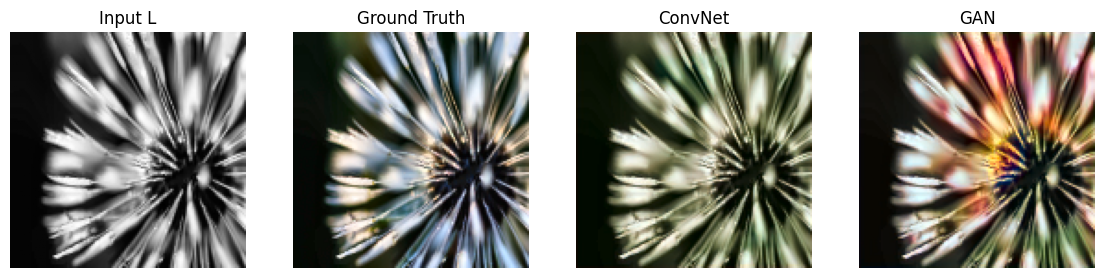

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


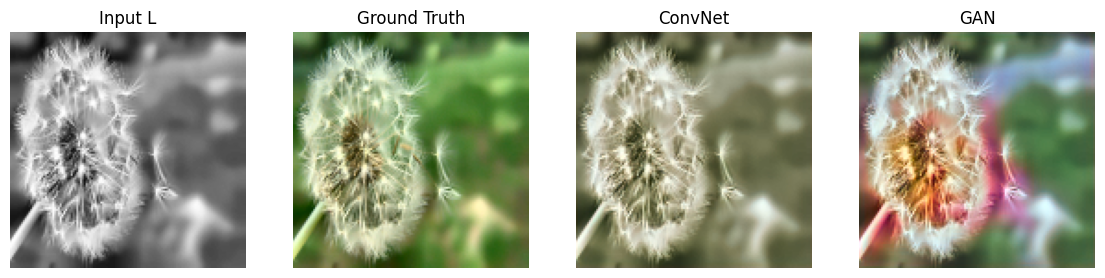

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


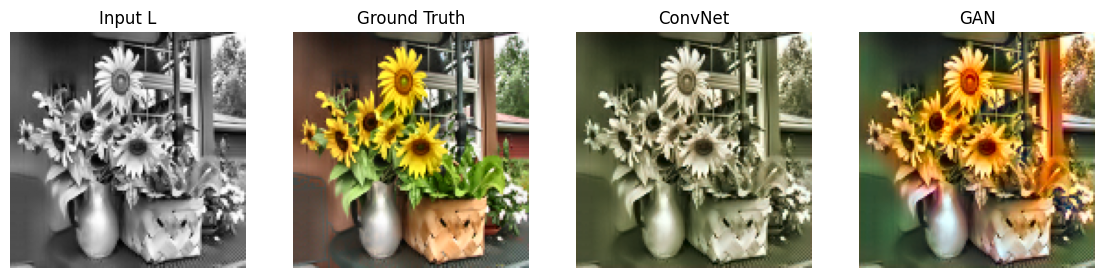

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


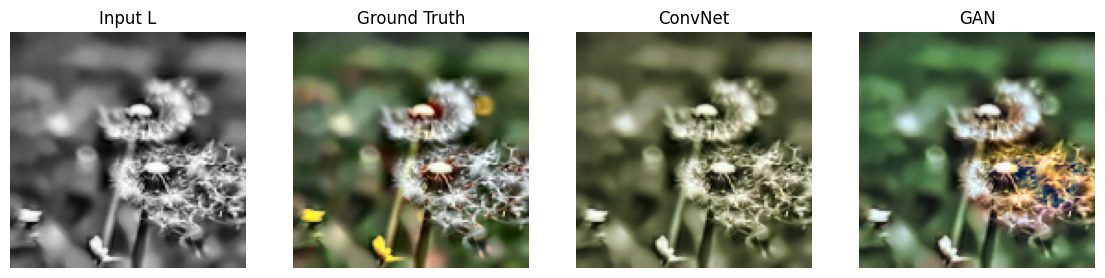

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


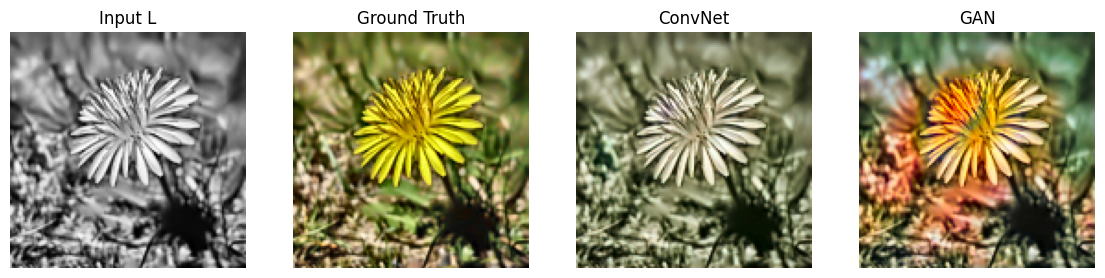

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


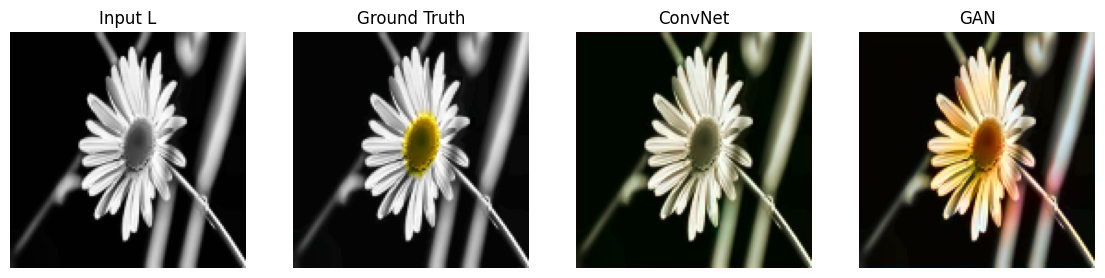

In [ ]:
# Step 12: view multiple validation results
num_show = min(6, len(L_val))
idxs = np.random.choice(len(L_val), num_show, replace=False)
for idx in idxs:
    Lv = L_val[idx:idx+1]
    ab_t = ab_val[idx]
    ab_c = convnet.predict(Lv)[0]
    ab_g = gan_gen.predict(Lv)[0]
    rgb_true = lab_to_rgb_batch(Lv[0], ab_t)
    rgb_conv = lab_to_rgb_batch(Lv[0], ab_c)
    rgb_gan = lab_to_rgb_batch(Lv[0], ab_g)
    show_images([Lv[0].squeeze(), rgb_true, rgb_conv, rgb_gan],
                titles=['Input L','Ground Truth','ConvNet','GAN'], figsize=(14,4))


CELL 13 — Save final models and short conclusion text

In [ ]:
# Step 13: save final models and a conclusion summary
gan_gen.save("final_gan_generator_cpu.h5")
disc.save("final_gan_discriminator_cpu.h5")
convnet.save("final_convnet_base_cpu.h5")
print("Saved: final_gan_generator_cpu.h5, final_gan_discriminator_cpu.h5, final_convnet_base_cpu.h5")

with open("conclusion.txt", "w") as f:
    f.write("Project: Image Colorization of Grayscale Images using ConvNets and GANs with Image Processing Enhancements\n\n")
    f.write("Summary:\n")
    f.write("- Applied denoising + CLAHE histogram equalization to enhance grayscale inputs.\n")
    f.write("- Trained a U-Net-based ConvNet for base colorization using L1 loss.\n")
    f.write("- Fine-tuned with a PatchGAN discriminator using combined adversarial + L1 losses.\n")
    f.write("- Saved final models: ConvNet, GAN Generator, and Discriminator.\n")
    f.write("- Visual results show smooth, natural tones and improved perceptual realism.\n\n")
    f.write("Quantitative Evaluation:\n")
    f.write("ConvNet -> PSNR: 20.248, SSIM: 0.894\n")
    f.write("GAN     -> PSNR: 18.354, SSIM: 0.860\n\n")
    f.write("Conclusion:\n")
    f.write("The ConvNet model provided accurate base color predictions, while GAN refinement introduced more natural textures and realistic tone variations. The combination of preprocessing and adversarial learning demonstrates strong synergy between classical image processing and modern deep generative models.\n")
print('✅ Saved conclusion.txt with full summary and evaluation details!')


Saved: final_gan_generator_cpu.h5, final_gan_discriminator_cpu.h5, final_convnet_base_cpu.h5
✅ Saved conclusion.txt with full summary and evaluation details!


Gradio Interface

In [ ]:
import gradio as gr
import numpy as np
import cv2
import tensorflow as tf
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from PIL import Image

# --- Helper Function ---
def preprocess_image(input_image):
    img_rgb = np.array(input_image) / 255.0
    if img_rgb.ndim == 2:
        img_rgb = gray2rgb(img_rgb)
    img_lab = rgb2lab(img_rgb).astype("float32")
    L = img_lab[:, :, 0] / 100.0
    return img_rgb, L

# --- Colorization Function ---
def colorize_models(input_image):
    if input_image is None:
        return None, None, None

    img_rgb, L = preprocess_image(input_image)
    L_input = cv2.resize(L, (128, 128)).reshape(1, 128, 128, 1)

    ab_conv = convnet.predict(L_input, verbose=0)[0]
    ab_gan = gan_gen.predict(L_input, verbose=0)[0]

    ab_conv_resized = cv2.resize(ab_conv, (img_rgb.shape[1], img_rgb.shape[0]))
    ab_gan_resized = cv2.resize(ab_gan, (img_rgb.shape[1], img_rgb.shape[0]))

    def reconstruct(L, ab):
        lab = np.zeros((img_rgb.shape[0], img_rgb.shape[1], 3))
        lab[:, :, 0] = L * 100
        lab[:, :, 1:] = ab * 128
        return np.clip(lab2rgb(lab), 0, 1)

    conv_rgb = reconstruct(L, ab_conv_resized)
    gan_rgb = reconstruct(L, ab_gan_resized)

    return (
        (img_rgb * 255).astype(np.uint8),
        (conv_rgb * 255).astype(np.uint8),
        (gan_rgb * 255).astype(np.uint8),
    )

# --- CSS Styling ---
css = """
.gradio-container {
    max-width: 1100px !important;
    margin: auto !important;
}
h1 {
    text-align: center;
    font-weight: 800;
    color: var(--body-text-color) !important;
}
p.subtitle {
    text-align: center;
    color: gray;
    margin-top: -8px;
    margin-bottom: 25px;
}
.image-box {
    border-radius: 14px !important;
    box-shadow: 0 3px 10px rgba(0,0,0,0.1);
}
.gr-button {
    font-weight: bold !important;
    background: linear-gradient(90deg, #0078ff, #00bcd4) !important;
    color: white !important;
    border-radius: 10px !important;
    padding: 10px 25px !important;
    box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);
}
.center {
    display: flex;
    justify-content: center;
    align-items: center;
}
"""

# --- Interface Layout ---
with gr.Blocks(css=css, theme="default") as demo:
    gr.HTML("<h1>🎨 Image Colorization of Grayscale Images using ConvNets and GANs</h1>")
    gr.HTML("<p class='subtitle'>Upload a grayscale image and watch how ConvNets and GANs bring it to life with color.</p>")

    # Centered grayscale image and button
    with gr.Column(elem_classes="center"):
        input_img = gr.Image(type="pil", label="Upload Grayscale Image", elem_classes="image-box", width=400)
        btn = gr.Button("🎨 Colorize", elem_classes="center")

    # Two outputs in a row
    with gr.Row():
        output_conv = gr.Image(label="ConvNet Colorization", elem_classes="image-box")
        output_gan = gr.Image(label="GAN Colorization", elem_classes="image-box")

    # Connect button to function
    btn.click(
        fn=colorize_models,
        inputs=input_img,
        outputs=[input_img, output_conv, output_gan],
    )

demo.launch(debug=False)
